In [1]:
### IMPORTS
import pandas as pd
import os

In [2]:
### load beatmaps, user_random_df and user_top_df rest on demand because memory. 
# Define the base data directory
data_dir = os.path.join("../data", "processed")
beatmaps_path = os.path.join(data_dir, "beatmaps.csv")

beatmaps_df = pd.read_csv(beatmaps_path)
user_random_path = os.path.join(data_dir, "random_10000__users.csv")
user_random_df = pd.read_csv(user_random_path)
user_top_path = os.path.join(data_dir, "top_10000__users.csv")
user_top_df = pd.read_csv(user_top_path)

print("Initial datasets loaded into memory. Remaining data should be loaded on demand.")

Initial datasets loaded into memory. Remaining data should be loaded on demand.


### USER ANALYSIS


#### 1. Playtime distribution 
2 densitiy curves. on x "density on y" one line for random_users one line for top_users

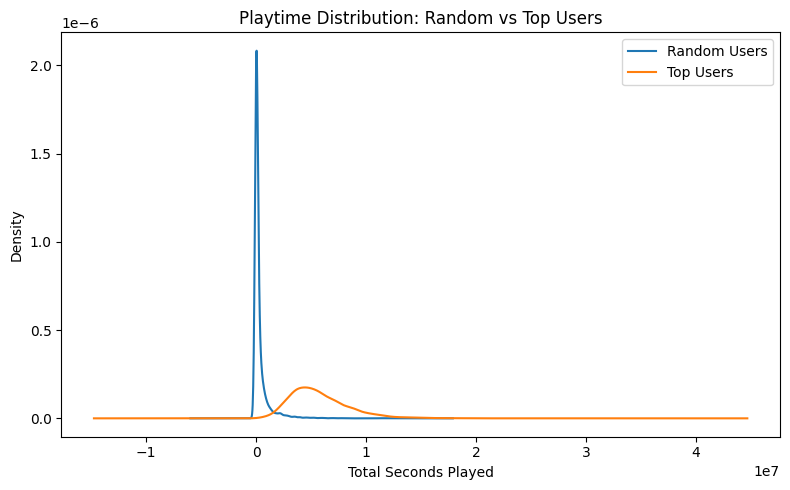

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
user_random_df['total_seconds_played'].plot(kind='kde', label='Random Users')
user_top_df['total_seconds_played'].plot(kind='kde', label='Top Users')
plt.xlabel('Total Seconds Played')
plt.ylabel('Density')
plt.title('Playtime Distribution: Random vs Top Users')
plt.legend()
plt.tight_layout()
plt.show()

#### 2. 2D Plot: (Nebeneinader Top user und Random)
top 10 Länder as Kreise, Kreis Größe ist Anzahl 
Y: playcount
X: total_seconds

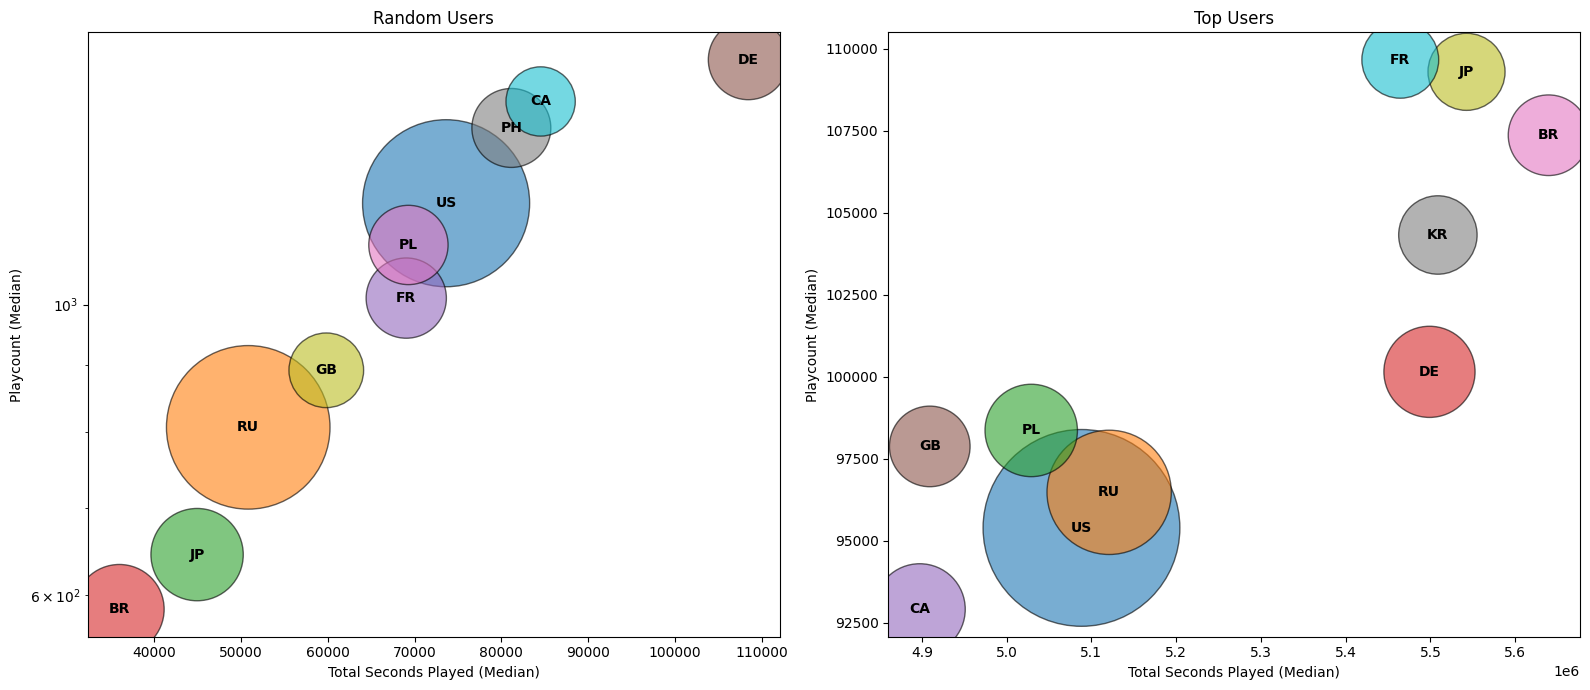

In [4]:
def plot_country_bubbles(df, ax, title, yscale='log'):
    grouped = df.groupby('country_acronym').agg({
        'playcount': 'median',
        'total_seconds_played': 'median',
        'user_id': 'count'
    }).rename(columns={'user_id': 'count'}).reset_index()
    grouped = grouped.sort_values('count', ascending=False).head(10)
    scatter = ax.scatter(
        grouped['total_seconds_played'],
        grouped['playcount'],
        s=grouped['count'] * 10,
        alpha=0.6,
        c=range(len(grouped)),
        cmap='tab10',
        edgecolor='k'
    )
    for _, row in grouped.iterrows():
        ax.annotate(
            row['country_acronym'],
            (row['total_seconds_played'], row['playcount']),
            fontsize=10, weight='bold', ha='center', va='center'
        )
    ax.set_xlabel('Total Seconds Played (Median)')
    ax.set_ylabel('Playcount (Median)')
    ax.set_title(title)
    ax.set_yscale(yscale)

fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=False)
plot_country_bubbles(user_random_df, axes[0], 'Random Users', yscale='log')
plot_country_bubbles(user_top_df, axes[1], 'Top Users', yscale='linear')
plt.tight_layout()
plt.show()


Matteo
#### Farm vs. Recrational metric plotten irgendwie
wenn möglich.

Matteo
#### Limits in phyisically challenging beatmap features.
wenn möglich

### BEATMAP ANALYSIS


#### 1. Long tail of beatmaps (beatmap_id not mod_beatmap_id) distribution of playcount

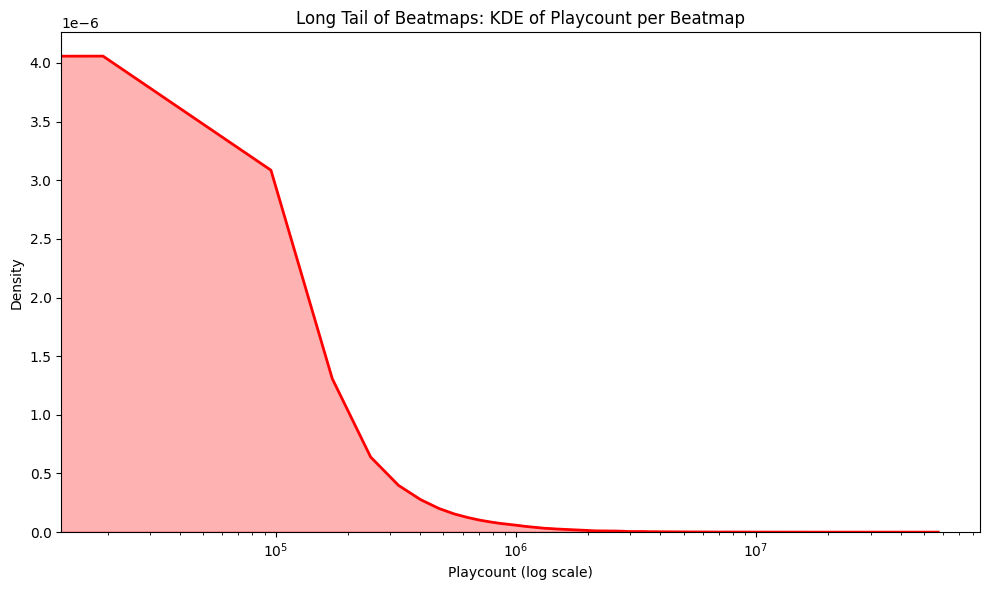

In [5]:
plt.figure(figsize=(10, 6))
beatmap_playcounts = beatmaps_df['playcount'].dropna().astype(int)
beatmap_playcounts = beatmap_playcounts[beatmap_playcounts > 0]  # Filter out zero playcounts
ax = beatmap_playcounts.plot(kind='kde', logx=True, color='red', linewidth=2)
x = ax.get_lines()[0].get_xdata()
y = ax.get_lines()[0].get_ydata()
plt.fill_between(x, y, color='red', alpha=0.3)
plt.xlabel('Playcount (log scale)')
plt.ylabel('Density')
plt.title('Long Tail of Beatmaps: KDE of Playcount per Beatmap')
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()


Sonja
#### 2. beatmaps anzahl über Zeit. 

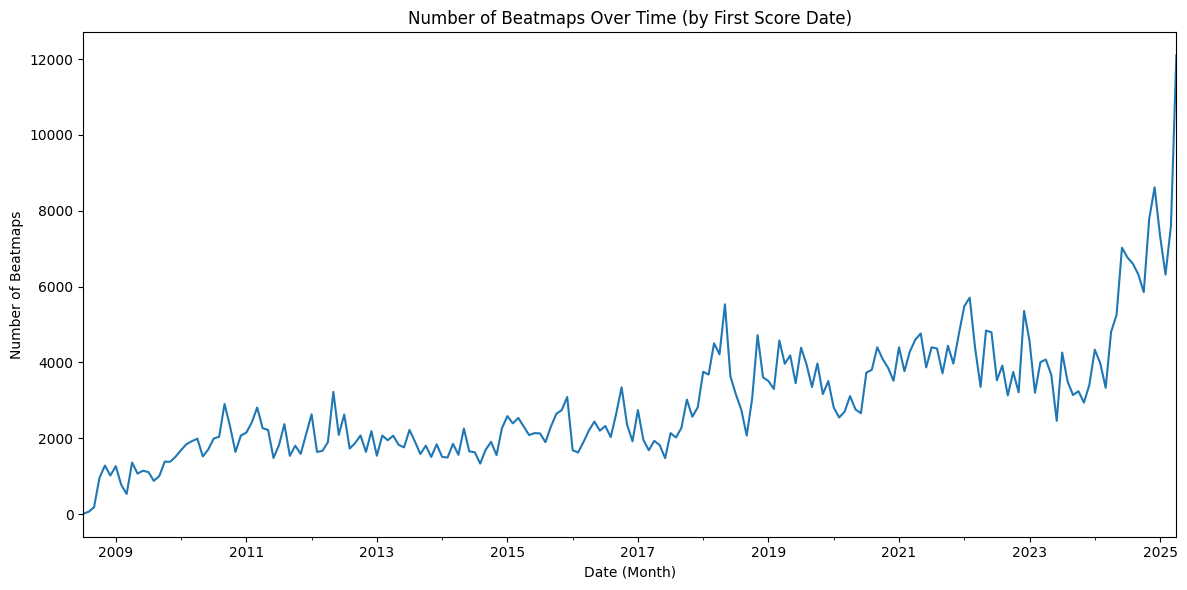

In [6]:
# Load scores.csv on demand
random_scores_path = os.path.join(data_dir, "random_10000__scores.csv")
top_scores_path = os.path.join(data_dir, "top_10000__scores.csv")
random_scores_df = pd.read_csv(random_scores_path, usecols=['beatmap_id', 'date'])
top_scores_df = pd.read_csv(top_scores_path, usecols=['beatmap_id', 'date'])
scores_df = pd.concat([random_scores_df, top_scores_df], ignore_index=True)

# Convert date column to datetime
scores_df['date'] = pd.to_datetime(scores_df['date'], errors='coerce')

# Get the first score date for each beatmap
first_score_dates = scores_df.groupby('beatmap_id')['date'].min().reset_index()
first_score_dates.rename(columns={'date': 'first_score_date'}, inplace=True)

# Merge with beatmaps_df
beatmaps_df = beatmaps_df.merge(first_score_dates, left_on='beatmap_id', right_on='beatmap_id', how='left')

# Plot the number of beatmaps over time using first_score_date
beatmaps_df['first_score_date'] = pd.to_datetime(beatmaps_df['first_score_date'], errors='coerce')
beatmaps_per_month = beatmaps_df.groupby(beatmaps_df['first_score_date'].dt.to_period('M')).size()

plt.figure(figsize=(12, 6))
beatmaps_per_month.plot()
plt.xlabel('Date (Month)')
plt.ylabel('Number of Beatmaps')
plt.title('Number of Beatmaps Over Time (by First Score Date)')
plt.tight_layout()
plt.show()

Matteo
#### 2. Map Archetype Sketch. 
3D plot plotting beatmaps along the 3 dimensions: speed, aim, technicality(combination of slider_factor and failrate maybe or something similar), and color of points should be scaled along diffstart rating.
Assumption: Patterns will emerge. 

Matteo
#### how extreme values in "constraint features" reduce players. 

### SCORE ANALYSIS 

Sonja 
# features where formulas changed over time: 
- pp (Variance über Jahre innerhalb Intervalle.)  Anfang intervall - EnderIntervall Änderung des Durchschnitt
- diff_star_rating

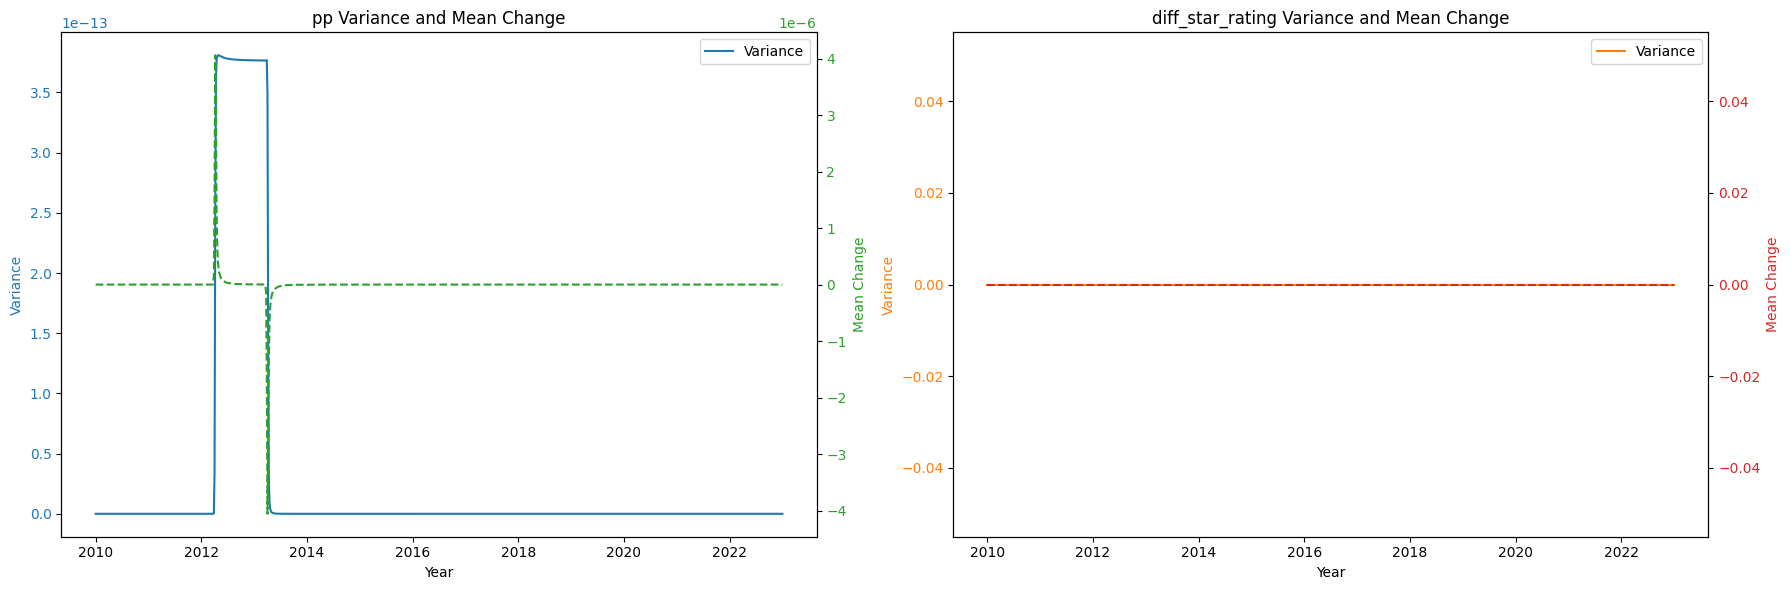

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharex=True)

# Plot for pp
axes[0].plot(y_stats_df['year'], y_stats_df['variance'], label='Variance', color='tab:blue')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Variance', color='tab:blue')
axes[0].tick_params(axis='y', labelcolor='tab:blue')
axes[0].set_title('pp Variance and Mean Change')
ax2 = axes[0].twinx()
ax2.plot(y_stats_df['year'], y_stats_df['mean_change'], label='Mean Change', color='tab:green', linestyle='--')
ax2.set_ylabel('Mean Change', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')
axes[0].legend(['Variance', 'Mean Change'], loc='upper right')

# Plot for diff_star_rating if available
if 'diff_star_rating_stats_df' in locals():
    axes[1].plot(diff_star_rating_stats_df['year'], diff_star_rating_stats_df['variance'], label='Variance', color='tab:orange')
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('Variance', color='tab:orange')
    axes[1].tick_params(axis='y', labelcolor='tab:orange')
    axes[1].set_title('diff_star_rating Variance and Mean Change')
    ax4 = axes[1].twinx()
    ax4.plot(diff_star_rating_stats_df['year'], diff_star_rating_stats_df['mean_change'], label='Mean Change', color='tab:red', linestyle='--')
    ax4.set_ylabel('Mean Change', color='tab:red')
    ax4.tick_params(axis='y', labelcolor='tab:red')
    axes[1].legend(['Variance', 'Mean Change'], loc='upper right')
else:
    axes[1].set_visible(False)

plt.tight_layout()
plt.show()
